IA & Data science (LU3IN0226) -- 2023-2024
--------
*&copy; Equipe pédagogique: Téo Guichoux, Christophe Marsala, Olivier Schwander, Jean-Noël Vittaut.*


# TD-TME09: algorithme des k-moyennes

L'objectif de ce notebook est d'implémenter l'algorithme des K-moyennes.

<font size="+1" color="RED">**[Q]**</font> **Indiquer dans la boîte ci-dessous vos noms et prénoms :**

Warintara MUNSUP 28707636
Snkar Mam 21300810

<font color="RED" size="+1"><b>[Q]</b></font> **Renommer ce fichier ipython**

**Nom à donner au fichier à poster** : *tme-10-Nom1_Nom2.ipynb* 
- *Nom1* et *Nom2* : noms des membres du binôme
- ne pas compresser ou faire une archive: il faut rendre le fichier ipython tel quel, éventuellement, si vous avez d'autres fichiers vous les rendez séparément.

**Echancier pour la soumission de votre compte-rendu:**
- le compte-rendu d'une séance doit être remis obligatoirement <font color="RED">avant la séance suivante</font>.

**Le compte-rendu est soumis sur la page Moodle.**

## Préparation 

Si vous ne l'avez pas fait lors de la séance précédente, commencer par créer un nouveau fichier de nom `Clustering.py` dans votre répertoire `iads`.
Utilisez les premières lignes du fichier `Classifiers.py` pour débuter votre fichier `Clustering.py`, puis rajoutez dans ce fichier les fonctions écrites dans le TDTME 8:
- normalisation
- dist_euclidienne
- centroide, dist_centroides
- initialise, fusionne, clustering_hierarchique
- toutes les autres fonctions écrites

**Remarque**: il est nécessaire d'ajouter des imports utilisés dans le TDTME 8 dans le fichier `Clustering.py`.

Pensez aussi à ajouter vos fonctions pour contruire les arbres de décision numériques dans votre fichier `Classifiers.py`.

In [1]:
# Importation de librairies standards:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline  

# un nouvel import utile pour la 3D:
from matplotlib import cm

# Les instructions suivantes sont TRES utiles pour recharger automatiquement 
# le code modifié dans les librairies externes
%load_ext autoreload
%autoreload 2

# Pour mesurer le temps
import time

# Importation de votre librairie iads:
# La ligne suivante permet de préciser le chemin d'accès à la librairie iads
import sys
sys.path.append('../')   # iads doit être dans le répertoire père du répertoire courant !

# Importation de la librairie iads
import iads as iads

# importation de Classifiers
from iads import Classifiers as classif

# importation de utils
from iads import utils as ut

# importation de evaluation
from iads import evaluation as ev

# importation de Clustering
from iads import Clustering as clust

# commande TRES utile pour recharger automatiquement le code que vous modifiez dans les modules
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Travail à réaliser
Le travail à faire se décompose en 2 phases :
- dans un premier temps, le travail porte sur la base d'apprentissage <code>base-2D.csv</code> qui contient des exemples décrits dans $R^2$. Ainsi, il est plus aisé de visualiser les résultats des fonctions à écrire ;
- dans un second temps, les fonctions écrites dans la phase précédente sont à utiliser avec la base d'apprentissage `base-Paris.csv`.

Les 2 bases citées ont été fournies dans le TDTME 8, afin de ne pas les recopier, vous pouvez créer un <a href="https://fr.wikipedia.org/wiki/Lien_symbolique">lien symbolique</a> dans votre répertoire `tme-09` pour accéder au répertoire `data` du `tme-08`:

Placez-vous dans votre répertoire `tme-09` dans le terminal puis tapez:

    ln -s ../tme-08/data .
    
Une fois créé, si vous tapez `ls data` dans le répertoire `tme-09` vous aurez l'affichage du contenu du répertoire et les 2 bases seront accessibles directement par `data/base-2D.csv` et `data/base-Paris.csv`.




**Attention**: dans ce notebook, vos fonctions doivent **dès leur création** pouvoir s'appliquer **quelle que soit la dimension** des exemples traités.


### Données d'expérimentation

Commencer par charger le fichier <code>base_2D.csv</code> qui permettra d'expérimenter vos fonctions. Dans ce qui suit, on note <code>data_2D</code> le dataframe qui contient les données de ce fichiers.


In [2]:
data_2D = pd.read_csv("data/base-2D.csv")
data_2D[0:5] 

,X1,X2
0,0.0,4.0
1,1.0,3.5
2,1.0,1.0
3,2.0,1.0
4,2.0,2.0


### Vérification

On vérifie que tout est ok avec la librairie:

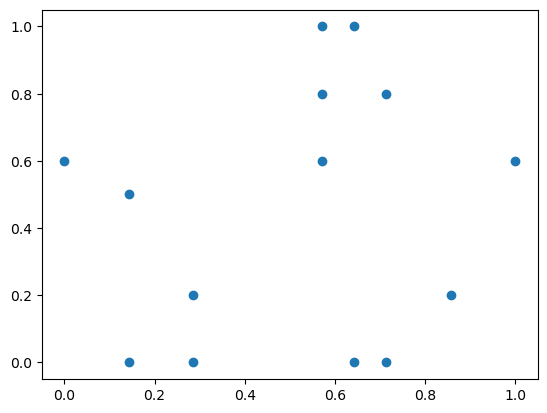

In [3]:
data_2D_norm = clust.normalisation(data_2D)

plt.scatter(data_2D_norm['X1'],data_2D_norm['X2'],)

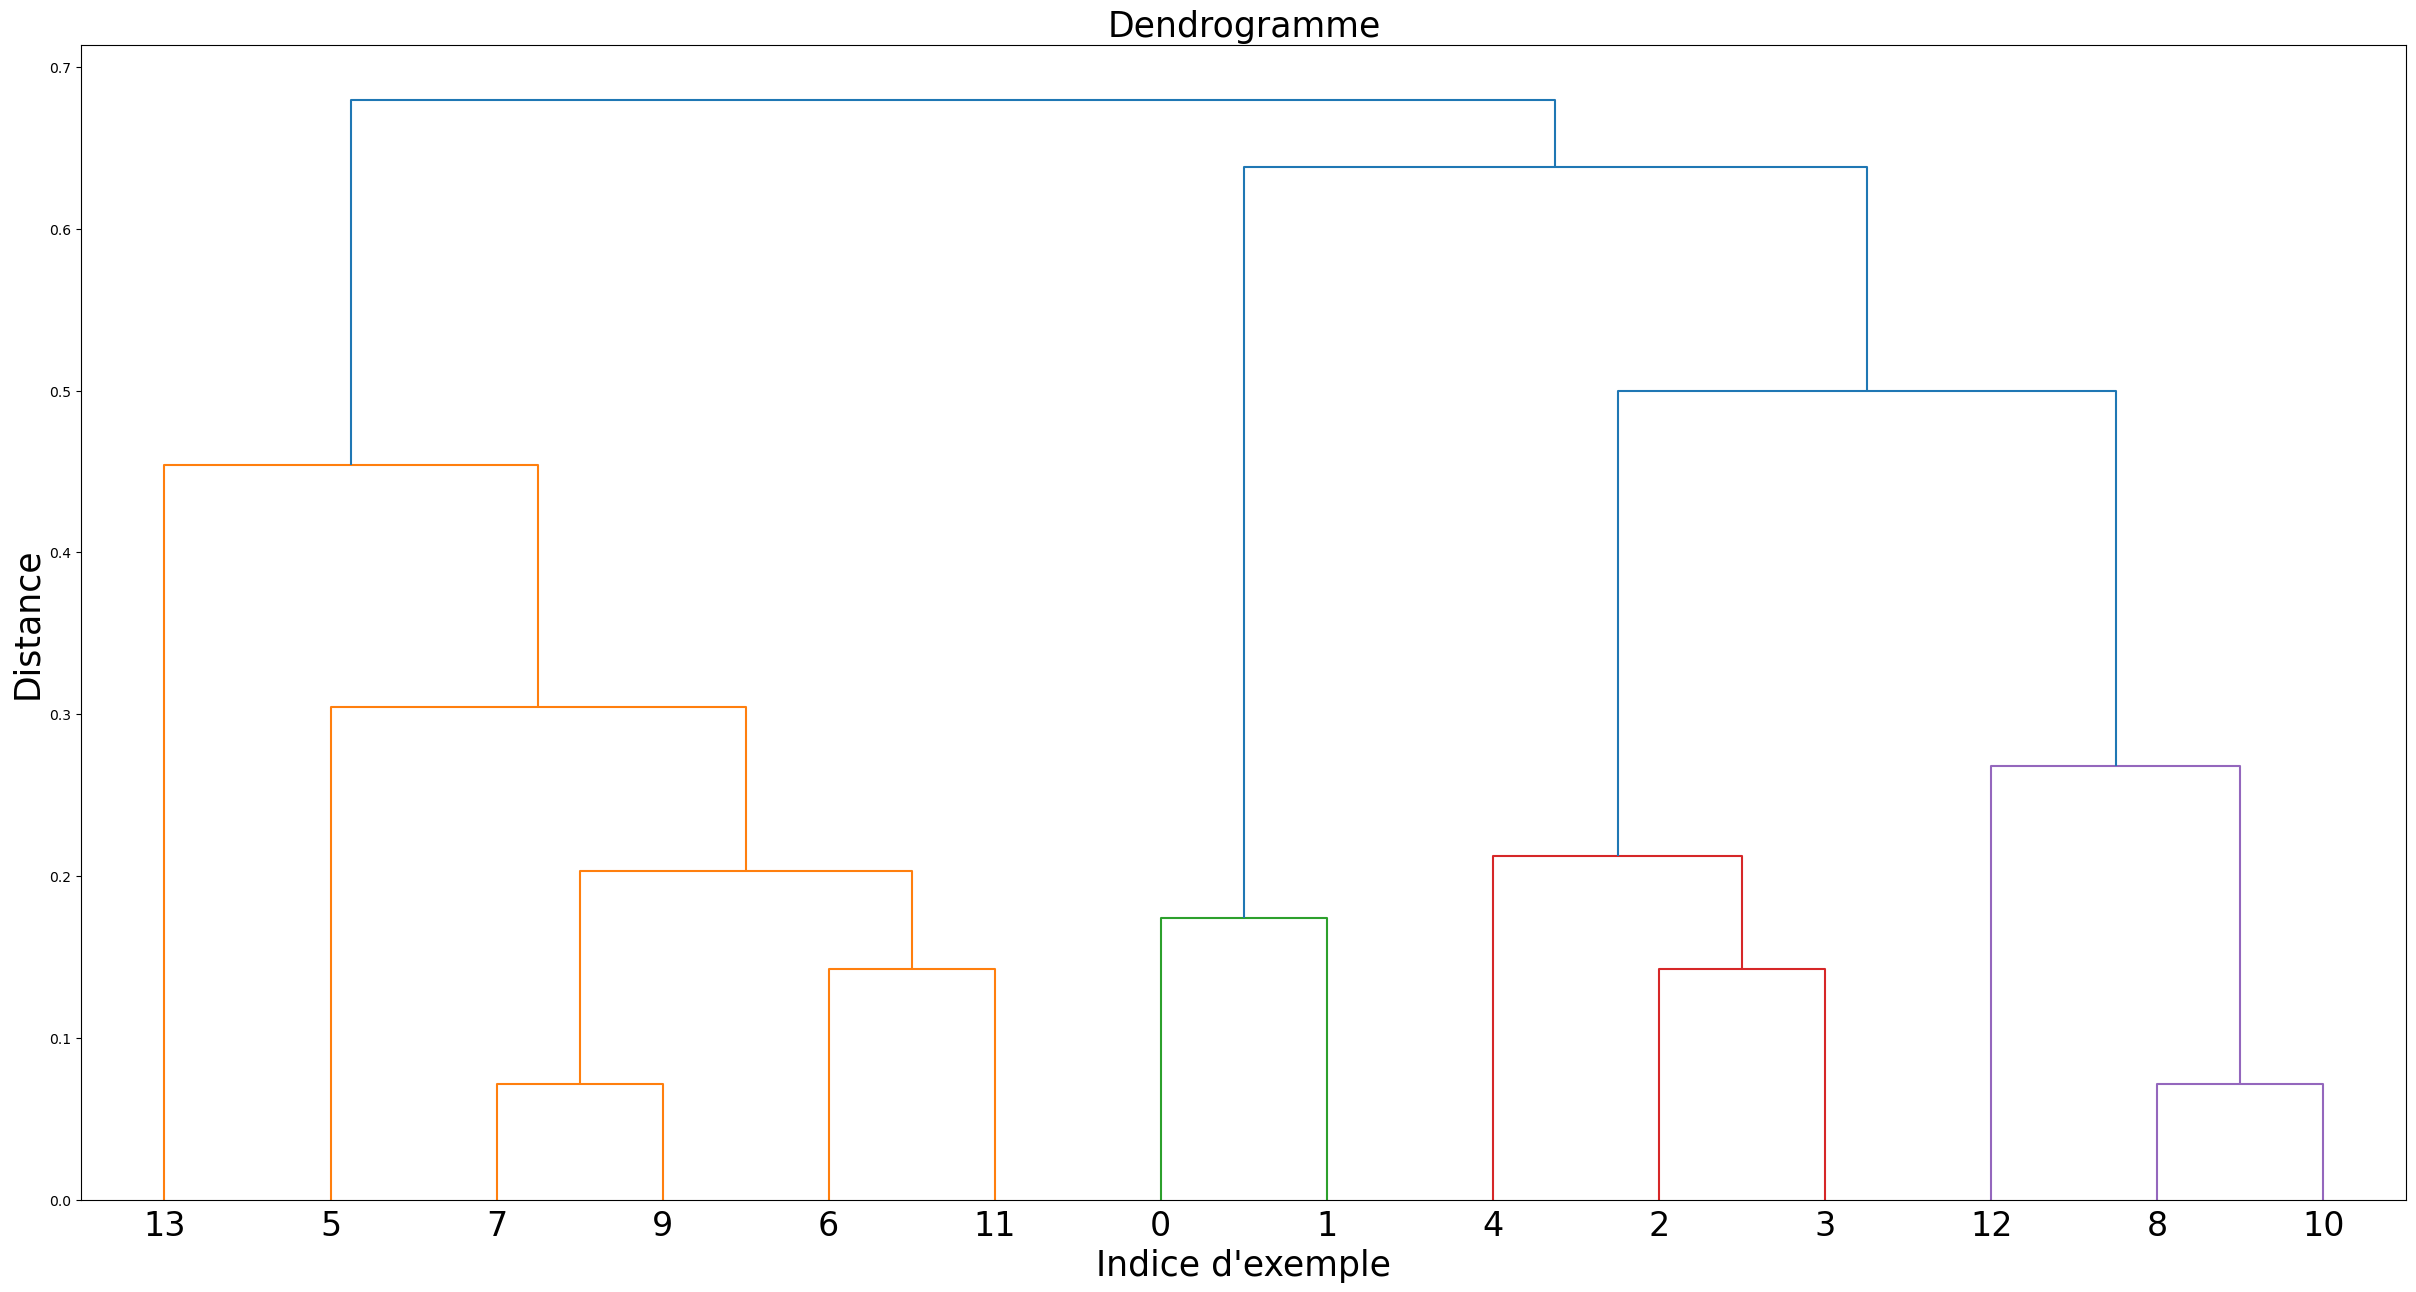

[[8, 10, 0.0714285714285714, 2],
 [7, 9, 0.07142857142857151, 2],
 [2, 3, 0.14285714285714285, 2],
 [6, 11, 0.1428571428571429, 2],
 [0, 1, 0.17437936593905287, 2],
 [15, 17, 0.20316375219039837, 4],
 [4, 16, 0.21237241067597867, 3],
 [12, 14, 0.26811891970176366, 3],
 [5, 19, 0.3047456282855976, 5],
 [13, 22, 0.4542857142857144, 6],
 [20, 21, 0.5000000000000001, 6],
 [18, 24, 0.638139657302555, 8],
 [23, 25, 0.6796842379114776, 14]]

In [4]:
clust.CHA_centroid(data_2D_norm,verbose=False,dendrogramme=True)

In [5]:
print("Centroide de toutes les données de la base:\n",clust.centroide(data_2D_norm))

Centroide de toutes les données de la base:
 [0.51020408 0.45      ]


## Implémentation des k-moyennes

### Inertie d'un cluster
<font size="+1" color="RED"><b>[Q]</b></font> Ecrire la fonction <code>inertie_cluster</code> qui, étant donné un  ensemble d'exemples (sous la forme d'un dataframe ou d'un np.array) contenant au moins 2 exemples, rend la valeur de l'inertie de cet ensemble telle qu'elle a été définie dans le cours.

In [6]:
def inertie_cluster(Ens):
    """ Array -> float
        Ens: array qui représente un cluster
        Hypothèse: len(Ens)> >= 2
        L'inertie est la somme (au carré) des distances des points au centroide.
    """
    cent = clust.centroide(Ens)
    somme = 0
    for elem in np.array(Ens) :
        somme += (clust.dist_euclidienne(elem,cent))**2 
    return somme 
        
    

In [7]:
print(f"inertie de l'ensemble : {inertie_cluster(data_2D_norm):1.4f}")


inertie de l'ensemble : 2.9760


<font size="+1" color="RED"><b>[Q]</b></font>  Ecrire la fonction <code>init_kmeans()</code> qui étant donné un entier $K>1$ et une base d'apprentissage de $n$ exemples rend un np.array composés de $K$ exemples tirés aléatoirement dans la base. On fait l'hypothèse que $K\leq n$.

**Remarque**: étudier les fonctions de la librairie random de Python...


In [8]:
import random
def init_kmeans(K,Ens):
    """ int * Array -> Array
        K : entier >1 et <=n (le nombre d'exemples de Ens)
        Ens: Array contenant n exemples
    """
    lens = np.array(Ens)
    ind = [i for i in range(0,len(lens))]
    np.random.shuffle(ind)
    l = ind[:K]
    
    return lens[l] 

In [9]:
np.random.seed(42)   # supprimer cette ligne une fois la mise au point terminée

# Par exemple (mais vous ne devriez pas pouvoir retrouver exactement les mêmes !)
Centroides_test = init_kmeans(3,data_2D_norm)
Centroides_test

array([[0.64285714, 1.        ],
       [0.71428571, 0.8       ],
       [0.        , 0.6       ]])

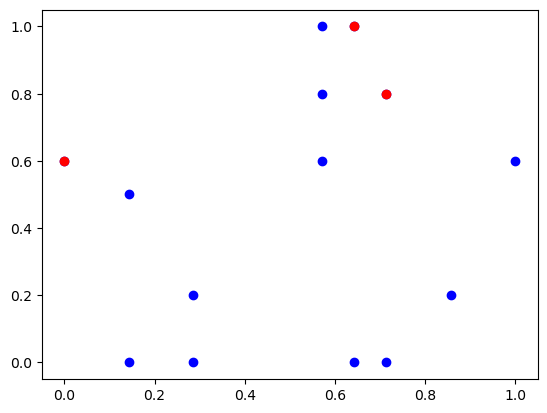

In [10]:
plt.scatter(data_2D_norm['X1'],data_2D_norm['X2'],color='blue')
plt.scatter(Centroides_test[:,0],Centroides_test[:,1],color='red')

<font size="+1" color="RED"><b>[Q]</b></font>  Ecrire la fonction <code>plus_proche()</code> qui, étant donné un exemple et un array contenant un ensemble de centroides, rend l'indice du centroide dont l'exemple est le plus proche.
En cas d'égalité de distance, le centroide de plus petit indice est choisi.

In [11]:
def plus_proche(Exe, Centres):
    """ Array * Array -> int
        Exe : Array contenant un exemple
        Centres : Array contenant les K centres
    """
    min_dist = float('inf')  # Initialise avec l'infini
    indice_plus_proche = -1

    for j, centre in enumerate(Centres):
        dist = clust.dist_euclidienne(Exe, centre)  # Calcul de la distance
        if dist < min_dist: 
            min_dist = dist
            indice_plus_proche = j
    return indice_plus_proche

    

In [12]:
# Exemple (vérifier le résultat avec l'affichage graphique réalisé précédemment):

for i in range(0,len(data_2D_norm)):
    pproche = plus_proche(data_2D_norm.iloc[i],Centroides_test)
    print("L'exemple ",i," est le plus proche du centroide ",pproche)

L'exemple  0  est le plus proche du centroide  2
L'exemple  1  est le plus proche du centroide  2
L'exemple  2  est le plus proche du centroide  2
L'exemple  3  est le plus proche du centroide  2
L'exemple  4  est le plus proche du centroide  2
L'exemple  5  est le plus proche du centroide  1
L'exemple  6  est le plus proche du centroide  1
L'exemple  7  est le plus proche du centroide  0
L'exemple  8  est le plus proche du centroide  1
L'exemple  9  est le plus proche du centroide  0
L'exemple  10  est le plus proche du centroide  1
L'exemple  11  est le plus proche du centroide  1
L'exemple  12  est le plus proche du centroide  1
L'exemple  13  est le plus proche du centroide  1


### Matrice d'affectation

Etant donné une base d'apprentissage, on représente une partition de cette base en K clusters à l'aide d'une matrice U contenant n lignes (une par exemple) et K colonnes (une par cluster) et telle que les contraintes suivantes sont vérifiées: 
- U[i,j] = 1 si l'exemple i appartient au cluster j
- U[i,j] = 0 si l'exemple i n'appartient pas au cluster j
- un exemple appartient à un et un seul cluster
- un cluster contient au moins un exemple

On appelle **matrice d'affectation** une telle matrice U.


<font size="+1" color="RED"><b>[Q]</b></font>  Donner une expression mathématique (pas du Python) des 2 dernières contraintes que vérifie une matrice d'affectation.

un exemple appartient à un et un seul cluster
∑j=1K​U[i,j]=1,∀i∈{1,2,…,n}
un cluster contient au moins un exemple
∑i=1n​U[i,j]≥1,∀j∈{1,2,…,K}

### Implémentation en Python
Nous utilisons un dictionnaire pour représenter d'une matrice d'affectation: 
- les clés de ce dictionnaire correspondent aux $K$ indices des clusters
- les valeurs correspondent à des listes d'indices d'exemples (leur indice dans la base d'apprentissage)

Dans tout ce qui suit, une "matrice d'affectation" sera un tel dictionnaire.


<font size="+1" color="RED"><b>[Q]</b></font>  Ecrire la fonction <code>affecte_cluster()</code> qui, étant donné une base d'apprentissage et un ensemble de $K$ centroïdes, rend la matrice d'affectation des exemples de la base aux clusters représentés par chaque centroïde.

In [13]:
from collections import OrderedDict
def affecte_cluster(Base,Centres):
    """ Array * Array -> dict[int,list[int]]
        Base: Array contenant la base d'apprentissage
        Centres : Array contenant des centroides
    """
    dic = dict()
    for i in range(0,len(Base)):
        c = plus_proche(Base.iloc[i], Centres)
        if c not in dic.keys() : 
            dic[c] = []
        dic[c].append(i)


    return dict(OrderedDict(sorted(dic.items())))

    

In [14]:
DictAffect = affecte_cluster(data_2D_norm, Centroides_test)
DictAffect

{0: [7, 9], 1: [5, 6, 8, 10, 11, 12, 13], 2: [0, 1, 2, 3, 4]}

### Ensemble des centroides
Grâce à la matrice d'affectation, on peut maintenant trouver les nouveaux centroides. Ceux-ci sont déterminés en prenant les moyennes des ensembles des exemples qui sont affectés au même cluster.

<font size="+1" color="RED"><b>[Q]</b></font>  Ecrire la fonction <code>nouveaux_centroides()</code> qui, étant donné une base d'apprentissage et une matrice d'affectation, rend l'ensemble des nouveaux centroides obtenus.

In [15]:

def nouveaux_centroides(Base,U):
    """ Array * dict[int,list[int]] -> DataFrame
        Base : Array contenant la base d'apprentissage
        U : Dictionnaire d'affectation
    """
    l = []
    for i in U.keys(): 
        l.append(list(clust.centroide(Base.iloc[U[i]])))
    return np.array(l)
        
    

In [16]:
data_2D_norm.iloc[DictAffect[0]]

,X1,X2
7,0.571429,1.0
9,0.642857,1.0


In [17]:
clust.centroide(data_2D_norm.iloc[DictAffect[0]])

array([0.60714286, 1.        ])

In [18]:
nouveaux_centroides(data_2D_norm, DictAffect)

array([[0.60714286, 1.        ],
       [0.7244898 , 0.42857143],
       [0.17142857, 0.26      ]])

### Inertie globale d'une partition

<font size="+1" color="RED"><b>[Q]</b></font>  En utilisant la fonction `inertie_cluster()`, écrire la fonction `inertie_globale()` qui, étant donné une base d'apprentissage et une matrice d'affectation, rend la valeur de l'inertie globale du partitionnement correspondant.


In [19]:
def inertie_globale(Base, U):
    """ Array * dict[int,list[int]] -> float
        Base : Array pour la base d'apprentissage
        U : Dictionnaire d'affectation
    """
    somme = 0
    for i in U.keys():
        somme += inertie_cluster(Base.iloc[U[i]])
    return somme

In [20]:
print(f'Inertie globale: {inertie_globale(data_2D_norm,DictAffect):1.4f}')

Inertie globale: 1.2732


### Algorithme des K-moyennes

<font size="+1" color="RED"><b>[Q]</b></font>  En utilisant les fonctions précédentes, implémenter l'algorithme des K-moyennes.
Pour cela, écrire une fonction <code>kmoyennes()</code> qui prend en argument un entier $K>1$, une base d'apprentissage, ainsi que deux nombres: un réel *epsilon*$>0$ et un entier *iter_max*$>1$, et qui rend un ensemble de centroides et une matrice d'affectation.

Le réel *epsilon* sert de critère de convergence, et l'entier *iter_max* est utilisé pour fixer un nombre d'itérations maximal servant à arrêter le calcul.

In [21]:
import numpy as np

def kmoyennes(K, Base, epsilon, iter_max):
    """
    int * Array * float * int -> tuple(Array, dict[int,list[int]])
    K : entier > 1 (nombre de clusters)
    Base : Array pour la base d'apprentissage
    epsilon : réel > 0
    iter_max : entier > 1
    """
    # Définir des centroides
    Centres = init_kmeans(K, Base)
    
    for i in range(iter_max):
        # définir matrice d'affectation
        Affect = affecte_cluster(Base, Centres)
        new_Centres = np.array([clust.centroide(Base.iloc[Affect[k]]) for k in range(K)] )
        # Calcul de l'inertie globale actuelle
        int_glo = inertie_globale(Base, Affect)
        # Critère de convergence
        if i > 0 and np.abs(int_glo - iner_pre) < epsilon:
            print("itération ",i," Inertie : ",int_glo," Difference: ",np.abs(int_glo - iner_pre))
            return (new_Centres, Affect)
    
        if i == 0 : 
            print("itération ",i," Inertie : ",int_glo," Difference: ",np.abs(int_glo))
        if i > 0 :
            print("itération ",i," Inertie : ",int_glo," Difference: ",np.abs(int_glo - iner_pre))
                  
        Centres = new_Centres
        iner_pre = int_glo
        
    return (Centres, Affect)

In [22]:
np.random.seed(42)   # supprimer cette ligne une fois la mise au point terminée

les_centres, l_affectation = kmoyennes(2, data_2D_norm, 0.05, 100)

print("Affichage des centres: ",les_centres)
print("Affichage des affectations: ",l_affectation)

itération  0  Inertie :  2.2482312925170067  Difference:  2.2482312925170067
itération  1  Inertie :  1.5128163265306123  Difference:  0.7354149659863944
itération  2  Inertie :  1.392091836734694  Difference:  0.12072448979591832
itération  3  Inertie :  1.392091836734694  Difference:  0.0
Affichage des centres:  [[0.67857143 0.8       ]
 [0.38392857 0.1875    ]]
Affichage des affectations:  {0: [5, 6, 7, 9, 11, 13], 1: [0, 1, 2, 3, 4, 8, 10, 12]}


In [23]:
np.random.seed(42)   # supprimer cette ligne une fois la mise au point terminée

les_centres, l_affectation = kmoyennes(3, data_2D_norm, 0.05, 100)

print("Affichage des centres: ",les_centres)
print("Affichage des affectations: ",l_affectation)

itération  0  Inertie :  1.2732099125364431  Difference:  1.2732099125364431
itération  1  Inertie :  0.9095408163265304  Difference:  0.3636690962099127
itération  2  Inertie :  0.8127244897959183  Difference:  0.09681632653061212
itération  3  Inertie :  0.8127244897959183  Difference:  0.0
Affichage des centres:  [[0.61428571 0.84      ]
 [0.80357143 0.2       ]
 [0.17142857 0.26      ]]
Affichage des affectations:  {0: [5, 6, 7, 9, 11], 1: [8, 10, 12, 13], 2: [0, 1, 2, 3, 4]}


On peut réaliser un affichage couleur des centroïdes trouvés:

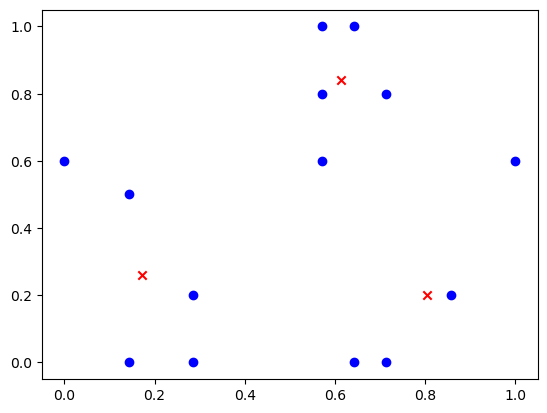

In [24]:
plt.scatter(data_2D_norm['X1'],data_2D_norm['X2'],color='b')
plt.scatter(les_centres[:,0],les_centres[:,1],color='r',marker='x')

<font size="+1" color="RED"><b>[Q]</b></font>  Ecrire la fonction <code>affiche_resultat()</code> qui permet d'afficher le résultat de l'algorithme en utilisant des couleurs différentes pour les clusters trouvés (pour faire simple, on peut ne considèrer que le cas où K est inférieur à 20).

*Remarque*: La librairie matplotlib permet de manipuler aisément des couleurs:
http://matplotlib.org/api/cm_api.html

Par exemple, on peut utiliser la table des couleurs (colormap) de nom `tab20` qui contient 20 couleurs différentes.

nombre de couleurs différentes 20


,X1,X2
0,0.000000,0.6
1,0.142857,0.5
2,0.142857,0.0
3,0.285714,0.0
4,0.285714,0.2
5,0.571429,0.6
6,0.571429,0.8
7,0.571429,1.0
8,0.642857,0.0
9,0.642857,1.0


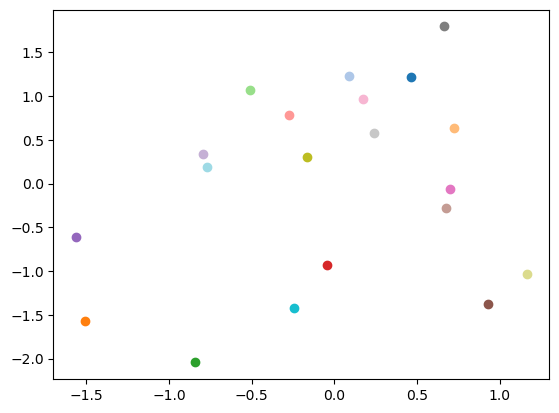

In [32]:
# Librairie pour manipuler les colormaps:
import matplotlib.cm as cm

# on transforme le colormap en couleurs utilisable par plt.scatter:
couleurs = cm.tab20(np.linspace(0, 1, 20))

print("nombre de couleurs différentes",len(couleurs))

# Pour voir ces couleurs, on va afficher 20 points aléatoirement définis:
x = np.random.randn(len(couleurs))
y = np.random.randn(len(couleurs))       

for (x,y,c) in zip(x,y,couleurs):
    plt.scatter(x, y, color=c)
data_2D_norm

In [53]:
import matplotlib.cm as cm


def affiche_resultat(Base, Centres, Affect):
    # Supposons que le nombre de clusters est égal au nombre de lignes dans Centres
    couleurs = cm.tab20(np.linspace(0, 1, len(Centres)))
    

    
    # Affichage des points par cluster
    for i, points_indices in Affect.items():
        plt.scatter(Base.iloc[points_indices, 0], Base.iloc[points_indices, 1], color=couleurs[i], label=f'Cluster {i}')
    
    # Affichage des centres des clusters
    for i, center_coords in enumerate(Centres):
        plt.scatter(center_coords[0], center_coords[1], color=couleurs[i], marker='x', s=100, label=f'Centre {i}')

    plt.show()


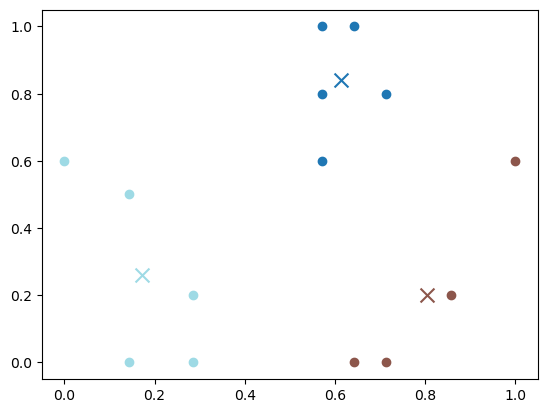

In [54]:
affiche_resultat(data_2D_norm,les_centres,l_affectation)

# Remarque:
#  - les centres sont représentés par des croix rouges

## Données différentes

In [29]:
data_2D_diff = clust.normalisation(pd.read_csv("data/base-2D-diff.csv"))
# ------------------------ 

print("Il y a", len(data_2D_diff), "exemples dans la base.")

data_2D_diff

plt.scatter(data_2D_diff['X1'],data_2D_diff['X2'],)

data_2D_norm

FileNotFoundError: [Errno 2] No such file or directory: 'data/base-2D-diff.csv'

In [ ]:
np.random.seed(42)   # supprimer cette ligne une fois la mise au point terminée

les_centres, l_affectation = kmoyennes(3, data_2D_diff, 0.05, 100)

print("Affichage des centres: ",les_centres)
print("Affichage des affectations: ",l_affectation)

affiche_resultat(data_2D_diff,les_centres,l_affectation)


In [ ]:
np.random.seed(1)   # supprimer cette ligne une fois la mise au point terminée

les_centres, l_affectation = kmoyennes(3, data_2D_diff, 0.05, 100)

print("Affichage des centres: ",les_centres)
print("Affichage des affectations: ",l_affectation)

affiche_resultat(data_2D_diff,les_centres,l_affectation)


## Beaucoup de points...

On essaye en générant aléatoire 1000 points, toujours en 2 dimensions.
Pour cela, on reprend la fonction `nb.random.multivariate_normal` que l'on a déjà utilisé dans le TME 2. On va générer la moitié des points selon une gaussienne centrée sur $(2,1)$ et l'autre moitié des points selon une gaussienne centrée sur $(-2-2)$. De cette façon, on créé artificiellement 2 paquets de points et on va regarder si l'algorithme des k-moyennes peut arriver à les retrouver.

In [ ]:
np.random.seed(42)   # on prend 42 comme graine


nb_points = 500 

# génération des groupes de points 
cluster1_centre = np.array([2,1])
cluster1_sigma = np.array([[1,0],[0,1]])
cluster2_centre = np.array([-2,-2])
cluster2_sigma = np.array([[1.5,0],[0,1.5]])
cluster1_points = np.random.multivariate_normal(cluster1_centre,cluster1_sigma,nb_points)
cluster2_points = np.random.multivariate_normal(cluster2_centre,cluster2_sigma,nb_points)

# on stocke les points dans un dataframe (en les normalisant)
desc = np.concatenate((cluster1_points, cluster2_points))
data_rand = clust.normalisation(pd.DataFrame(desc,columns=['X1','X2']))
    
print("Taille du dataset généré :", data_rand.shape[0], "exemples")

# Affichage des points obtenus:
plt.scatter(data_rand['X1'],data_rand['X2'])



In [ ]:
np.random.seed(42)   # supprimer cette ligne une fois la mise au point terminée

val_k = 2
les_centres, l_affectation = kmoyennes(val_k, data_rand, 0.05, 100)

print("Pour k=",val_k,"\nAffichage des centres: ",les_centres)
#print("Affichage des affectations: ",l_affectation)

affiche_resultat(data_rand,les_centres,l_affectation)


In [ ]:
# On peut essayer avec plus de clusters que prévu :

np.random.seed(42)   

val_k = 4
les_centres, l_affectation = kmoyennes(val_k, data_rand, 0.05, 100)

print("Pour k=",val_k,"\nAffichage des centres: ",les_centres)
#print("Affichage des affectations: ",l_affectation)

affiche_resultat(data_rand,les_centres,l_affectation)


In [ ]:
# Autre exécution avec le même k que précédemment

np.random.seed(2023)  

val_k = 4
les_centres, l_affectation = kmoyennes(val_k, data_rand, 0.05, 100)

print("Pour k=",val_k,"\nAffichage des centres: ",les_centres)
#print("Affichage des affectations: ",l_affectation)

affiche_resultat(data_rand,les_centres,l_affectation)


## Expérimentations

<font size="+1" color="RED"><b>[Q]</b></font>  Expérimenter l'algorithme des k-moyennes sur les données. Etudier l'impact du choix de $K$ sur l'inertie globale finale. Faire de même en relançant plusieurs fois l'algorithme avec la même valeur de $K$, en modifiant la valeur de epsilon ou de max_iter, etc.


<font size="+1" color="RED"><b>[Q]</b></font>  Expérimenter l'algorithme des k-moyennes sur les données de la base `base_Paris` vue dans le TDTME précédent.

Vous pouvez afficher les résultats obtenus avec le clustering hiérarchique afin de trouver une bonne valeur pour $K$.


## Questions de cours (à faire sur feuille)

Pour vous entraîner sans machine...

<font size="+1" color="RED"><b>[Q]</b></font>  On considère un ensemble fini $U$ d'éléments. 
- donner la fonction caractéristique de $U$
- donner la fonction caractéristique de l'ensemble vide
- soit $E$ et $F$ deux sous-ensembles de $U$ définis par leurs fonctions caractéristiques $\chi_E$ et $\chi_F$. En déduire les fonctions caractéristiques de $E\cup F$, de $E\cap F$ et de $E^{c}$. *(indice: penser au min et au max)*

<font size="+1" color="RED"><b>[Q]</b></font> Rappeler la définition d'une partition $P$ d'un ensemble $X$ en $K$ sous-ensembles. 
